In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Replace with your actual folder paths
adata1 = sc.read("10X-PBMC_counts_adata.h5ad")
adata2 = sc.read("PBMC_SSTX_counts_adata.h5ad")
adata3 = sc.read("PBMC_SSTX-xtrapA_counts_adata.h5ad")


In [ ]:
print(adata1.shape)
print(adata2.shape)
print(adata3.shape)
#print(adata4.shape)

for adatas in [adata1, adata2, adata3]:
    adatas.var.set_index('gene_ids', inplace=True)
    adatas.var.index.name = None

# Combine datasets and label batches
adata = ad.concat([adata1, adata2, adata3], 
   label="source", 
   keys=["10x-dUTSO", "TotalX", "TotalX-pA+"], #, "SSTX-pA~t"],
   join="inner",
   index_unique=None
   )

adata.var['gene_ids']=adata.var.index.copy()

In [ ]:
# Specify the path to the GTF file
gtf_file = "filtered_gene_id_biotypes.csv"

# Read the CSV file into a DataFrame
gtf_data = pd.read_csv(gtf_file)

gtf_data = gtf_data.drop_duplicates(subset='gene_id', keep='first')

# Function to append biotype to adata
def append_biotype(adata, gtf_data):
    # Ensure compatibility of gene_ids column
    adata.var = adata.var.copy()  # Avoid potential warnings about chained assignments
    adata.var["gene_ids"] = adata.var["gene_ids"].astype(str)
    gtf_data["gene_id"] = gtf_data["gene_id"].astype(str)
    
    # Merge on gene_ids and gene_id
    merged_var = adata.var.merge(
        gtf_data[["gene_id", "gene_name", "biotype"]],  # Only include relevant columns
        left_on="gene_ids",                # Match adata.var['gene_ids'] with gtf_data['gene_id']
        right_on="gene_id",
        how="left"
    )
    
    # Add biotype back to adata.var
    adata.var = merged_var
    
    # Fill missing biotype entries with "unknown"
    adata.var["biotype"] = adata.var["biotype"].fillna("unknown")
    
    return adata


# Apply the function to each AnnData object in the list
adata = append_biotype(adata, gtf_data)

adata.var.set_index('gene_name', inplace=True)
adata.var.index.name = None

In [ ]:
adata.obs_names_make_unique()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)
# 
# Subset to protein-coding genes
protein_coding_mask = adata.var['biotype'] == 'protein_coding'
protein_adata = adata[:, protein_coding_mask].copy()

sc.pp.scrublet(protein_adata, batch_key="source")

In [ ]:
adata.obs['doublet_score'] = protein_adata.obs['doublet_score']
adata.obs['predicted_doublet'] = protein_adata.obs['predicted_doublet']

In [ ]:
adata.write("PBMC_combined_raw_scrublet_3data.h5ad")

In [38]:
# Load the AnnData object from the .h5ad file
adata = sc.read("PBMC_combined_raw_scrublet_3data.h5ad")

/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [39]:
doublet_rate_per_source = adata.obs.groupby('source')['predicted_doublet'].mean()
print(doublet_rate_per_source)

adata.obs["predicted_doublet2"] = adata.obs["doublet_score"] > 0.1
doublet_rate_per_source2 = adata.obs.groupby('source')['predicted_doublet2'].mean()
print(doublet_rate_per_source2)


source
10X-dUTSO    0.118067
SSTX         0.080971
SSTX-pA+     0.076375
Name: predicted_doublet, dtype: float64
source
10X-dUTSO    0.168221
SSTX         0.108503
SSTX-pA+     0.116972
Name: predicted_doublet2, dtype: float64


/tmp/ipykernel_27889/3907391639.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  doublet_rate_per_source = adata.obs.groupby('source')['predicted_doublet'].mean()
/tmp/ipykernel_27889/3907391639.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  doublet_rate_per_source2 = adata.obs.groupby('source')['predicted_doublet2'].mean()


In [40]:
adata.var['gene_names']=adata.var.index.copy()

In [41]:
adata.var_names_make_unique()
# Calculate comprehensive QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=[], percent_top=None, log1p=False, inplace=True)
# Identify and calculate mitochondrial content
mt_gene_mask = adata.var_names.str.startswith(('MT-', 'mt-'))
mt_count = np.sum(mt_gene_mask)
print(f"Found {mt_count} mitochondrial genes")
if mt_count > 0:
    adata.var['mt'] = mt_gene_mask
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print("Mitochondrial metrics calculated.")
else:
    print("No mitochondrial genes found with standard prefixes.")
    adata.obs['pct_counts_mt'] = 0

Found 34 mitochondrial genes
Mitochondrial metrics calculated.


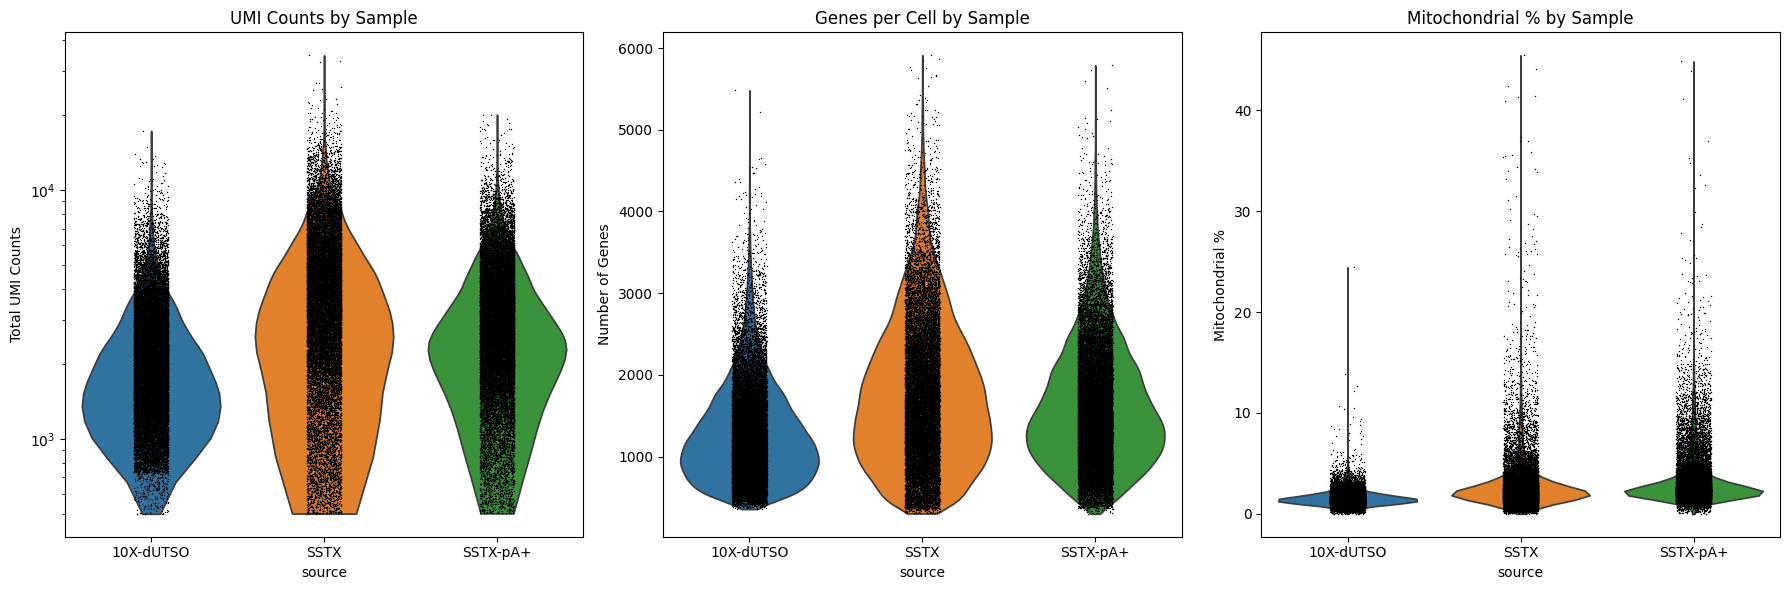

In [42]:
# Visualize QC metrics by sample to identify batch effects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# UMI counts by batch
sc.pl.violin(adata, 'total_counts', groupby='source', ax=axes[0], show=False)
axes[0].set_title('UMI Counts by Sample')
axes[0].set_ylabel('Total UMI Counts')
axes[0].set_yscale('log')

# Genes per cell by batch
sc.pl.violin(adata, 'n_genes_by_counts', groupby='source', ax=axes[1], show=False)
axes[1].set_title('Genes per Cell by Sample')
axes[1].set_ylabel('Number of Genes')

# Mitochondrial % by batch
sc.pl.violin(adata, 'pct_counts_mt', groupby='source', ax=axes[2], show=False)
axes[2].set_title('Mitochondrial % by Sample')
axes[2].set_ylabel('Mitochondrial %')
plt.tight_layout()
plt.show()

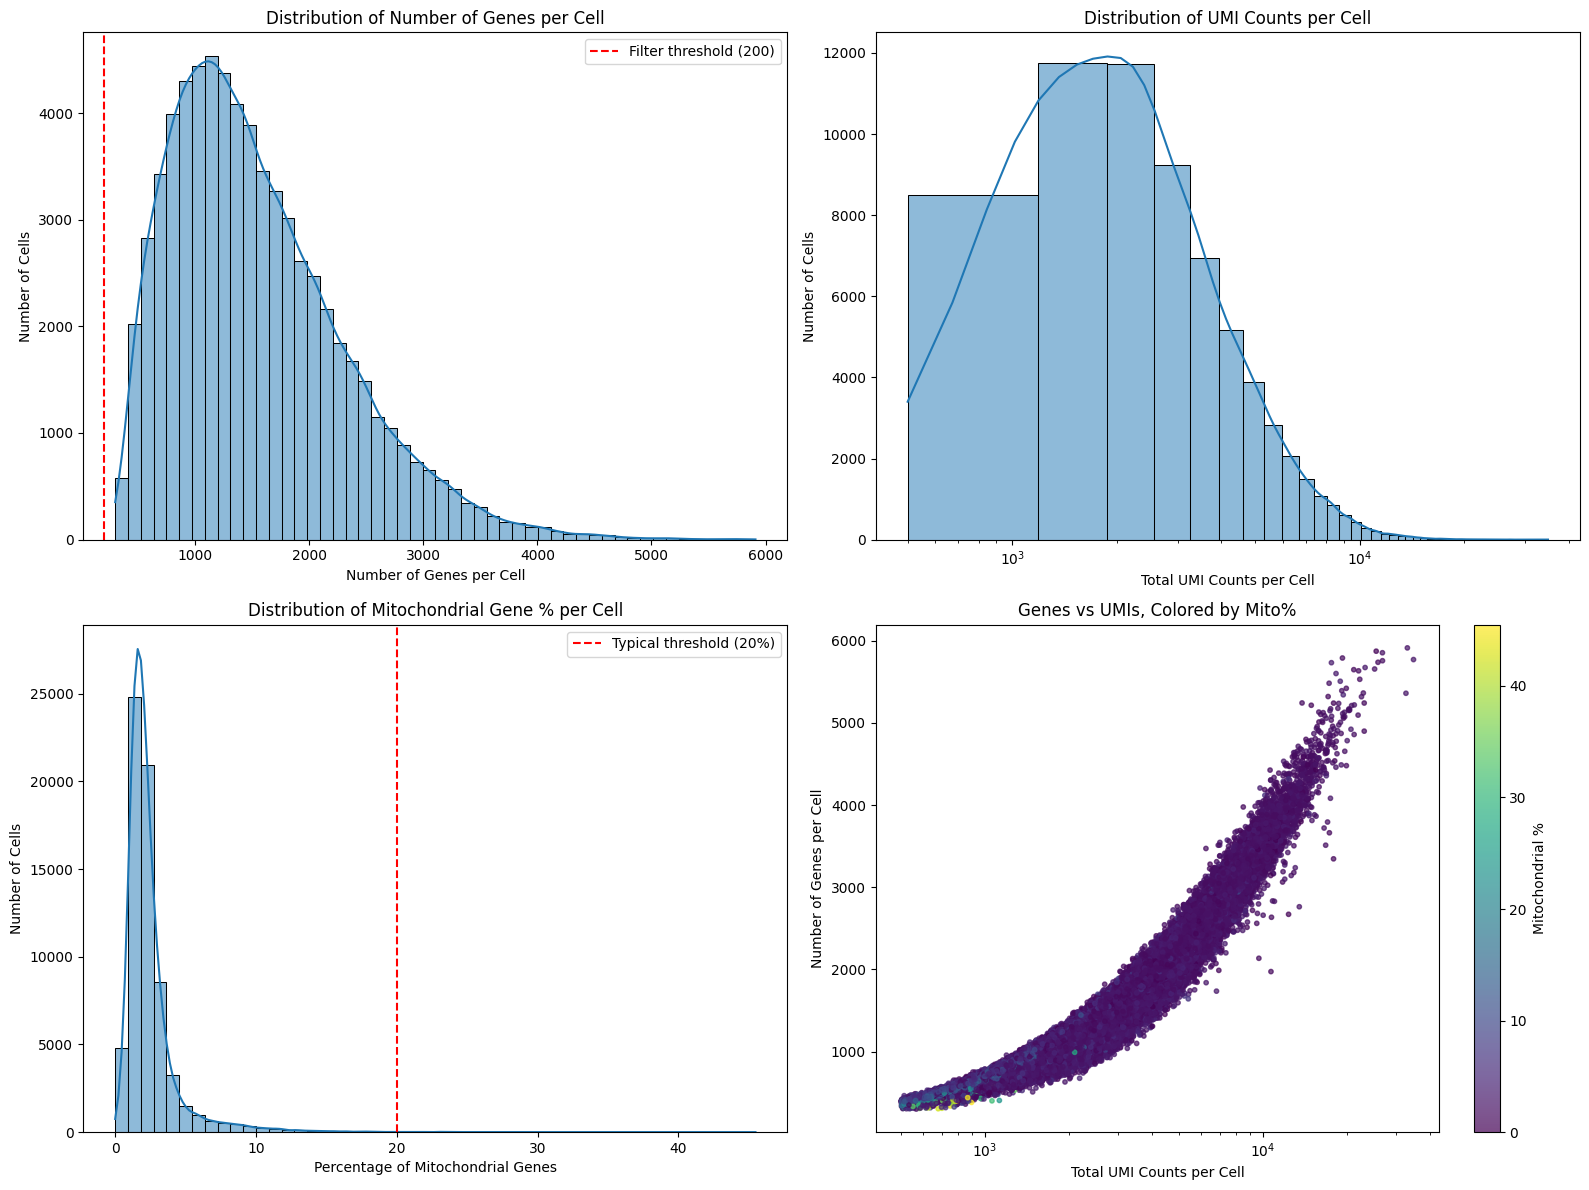

In [43]:
import seaborn as sns
# Visualize QC metrics 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Distribution of genes per cell
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_xlabel('Number of Genes per Cell')
axes[0, 0].set_ylabel('Number of Cells')
axes[0, 0].set_title('Distribution of Number of Genes per Cell')
axes[0, 0].axvline(200, color='red', linestyle='--', label='Filter threshold (200)')
axes[0, 0].legend()

# Distribution of UMI counts per cell
sns.histplot(adata.obs['total_counts'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_xlabel('Total UMI Counts per Cell')
axes[0, 1].set_ylabel('Number of Cells')
axes[0, 1].set_title('Distribution of UMI Counts per Cell')
axes[0, 1].set_xscale('log')

# Distribution of mitochondrial gene percentage
sns.histplot(adata.obs['pct_counts_mt'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Percentage of Mitochondrial Genes')
axes[1, 0].set_ylabel('Number of Cells')
axes[1, 0].set_title('Distribution of Mitochondrial Gene % per Cell')
axes[1, 0].axvline(20, color='red', linestyle='--', label='Typical threshold (20%)')
axes[1, 0].legend()

# Scatter plot of UMI count vs genes per cell colored by mito percent
scatter = axes[1, 1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], c=adata.obs['pct_counts_mt'], cmap='viridis', s=10, alpha=0.7)
axes[1, 1].set_xlabel('Total UMI Counts per Cell')
axes[1, 1].set_ylabel('Number of Genes per Cell')
axes[1, 1].set_title('Genes vs UMIs, Colored by Mito%')
axes[1, 1].set_xscale('log')
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Mitochondrial %')
plt.tight_layout()
plt.show()

In [44]:
max_mito = 15##    # Maximum percentage of mitochondrial genes (adjust based on your data)
max_counts = 5000  # Maximum UMI counts 

print(f"Before filtering: {adata.n_obs} cells, {adata.n_vars} genes")

# Filter cells based on QC metrics
adata = adata[(adata.obs['n_genes_by_counts'] <= max_counts) & (adata.obs['pct_counts_mt'] <= max_mito)]

print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes")

Before filtering: 67739 cells, 37228 genes
After filtering: 67421 cells, 37228 genes


In [45]:
# Remove doublets

#adata = adata[~adata.obs["predicted_doublet"]].copy()
adata = adata[adata.obs["doublet_score"] < 0.1].copy()

In [46]:
adata.layers["counts"] = adata.X.copy()

In [47]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [48]:
# Step 1: Create a temporary AnnData with only protein-coding genes
adata_protein_coding = adata[:, adata.var["biotype"] == "protein_coding"]


In [49]:
# Step 2: Identify highly variable genes among protein-coding genes
sc.pp.highly_variable_genes(adata_protein_coding, batch_key="source")

# Step 3: Transfer HVG labels back to the full dataset
adata.var["highly_variable"] = False  # Set all to False initially
adata.var.loc[adata_protein_coding.var_names[adata_protein_coding.var["highly_variable"]], "highly_variable"] = True

sc.pp.pca(adata, mask_var="highly_variable")
sc.pp.neighbors(adata)
sc.tl.umap(adata, random_state=42)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)  # Adjust resolution based on your dataset


/home/users/isakova/.local/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:700: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


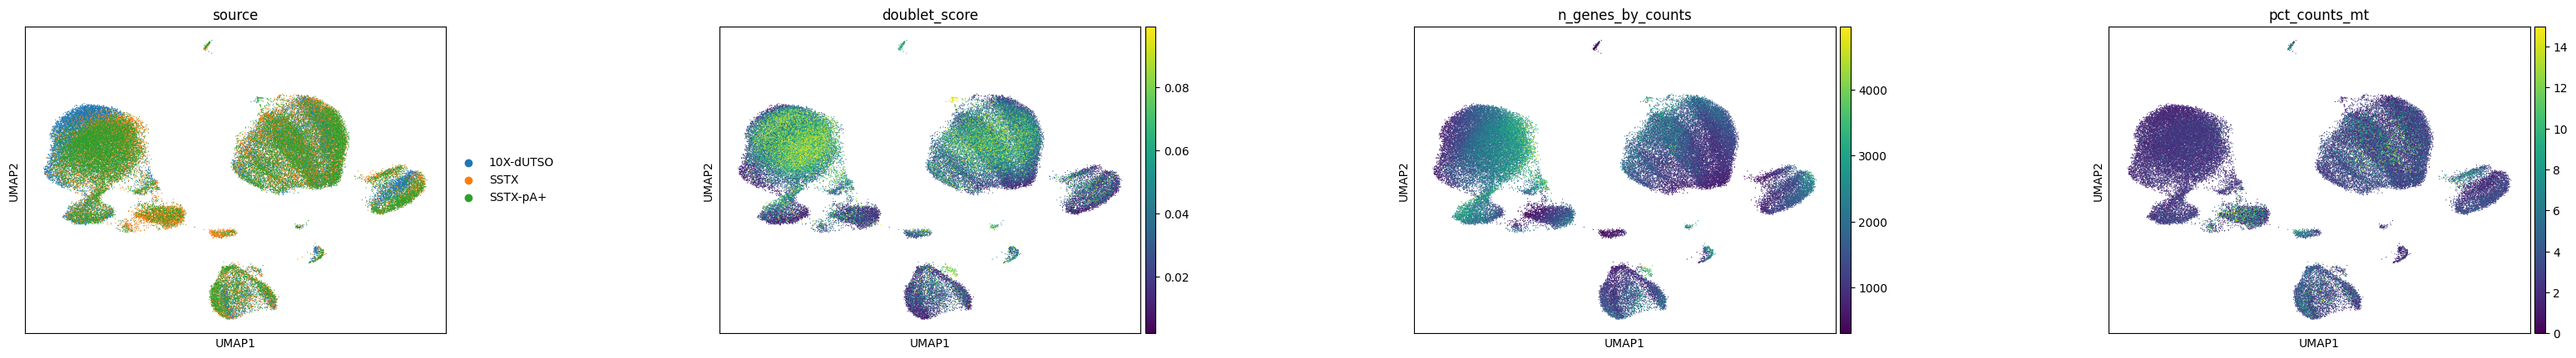

In [52]:
sc.pl.umap(
    adata,
    color=["source", "doublet_score","n_genes_by_counts", "pct_counts_mt"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
    #save="PBMC_umap_plot.pdf"
)

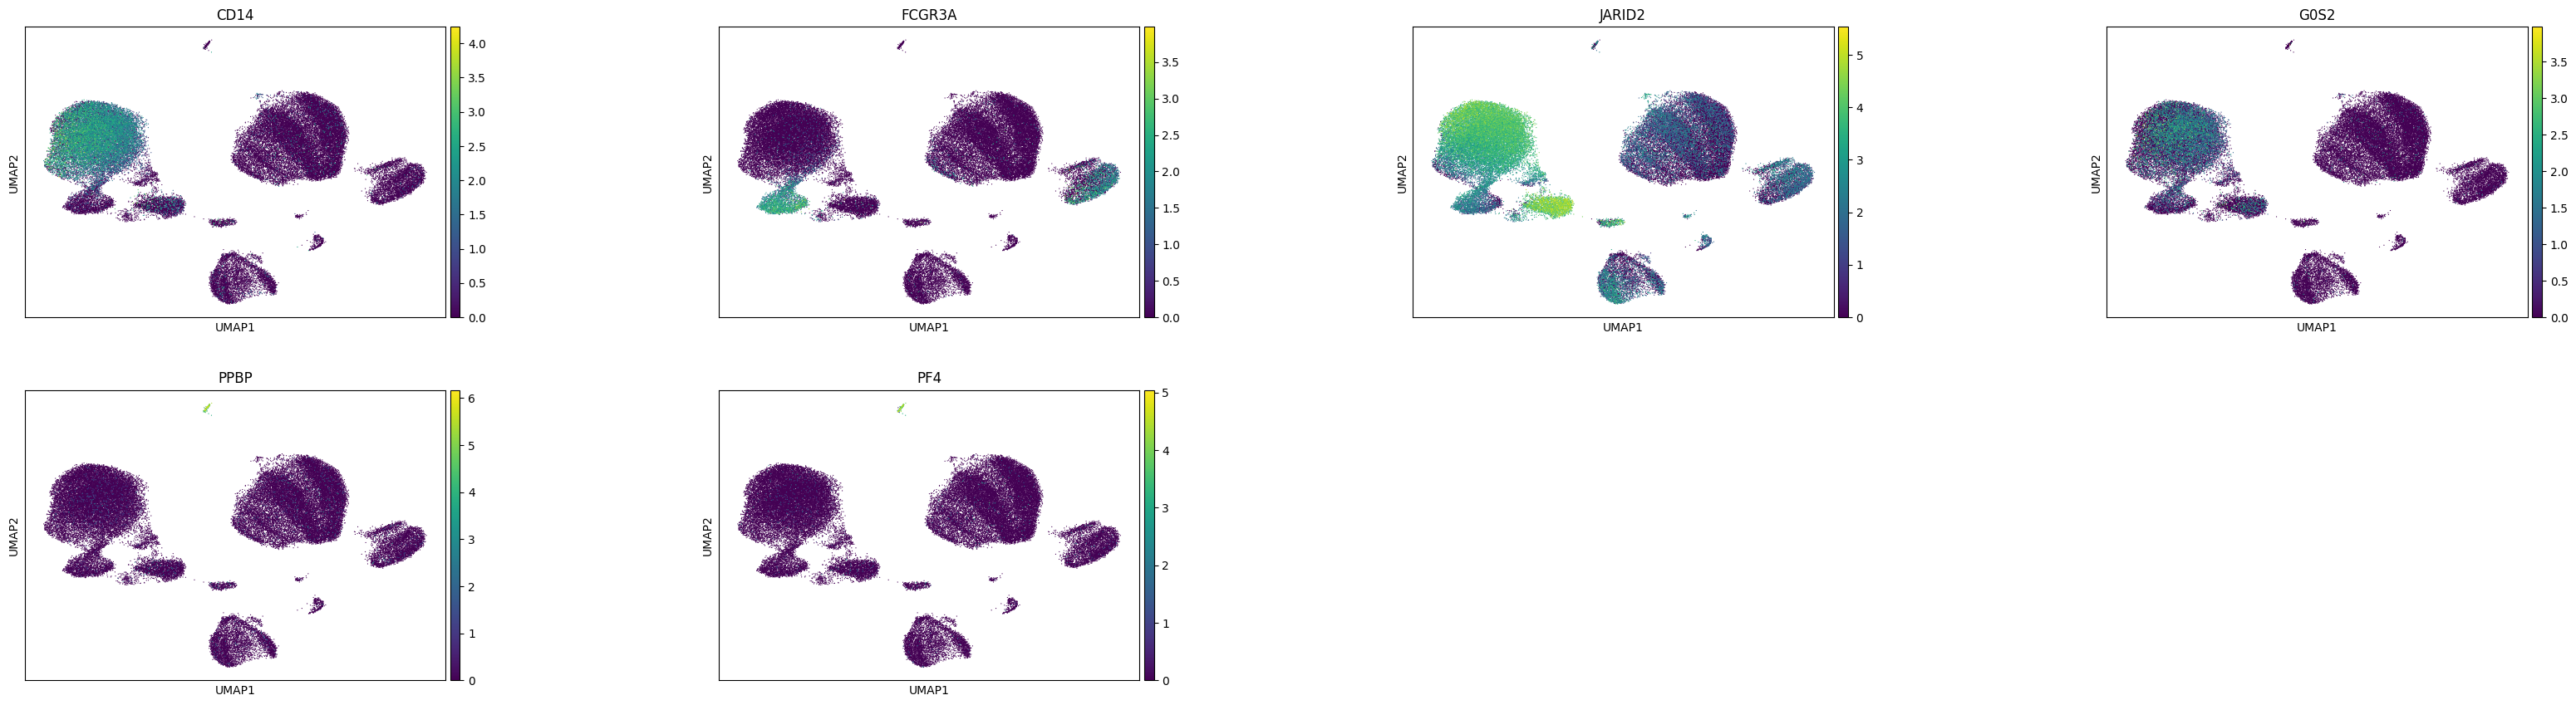

In [53]:
sc.pl.umap(
    adata,
    color=["CD14", "FCGR3A", "JARID2", "G0S2", "PPBP", "PF4"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

In [54]:
for res in [0.02, 0.1, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
)

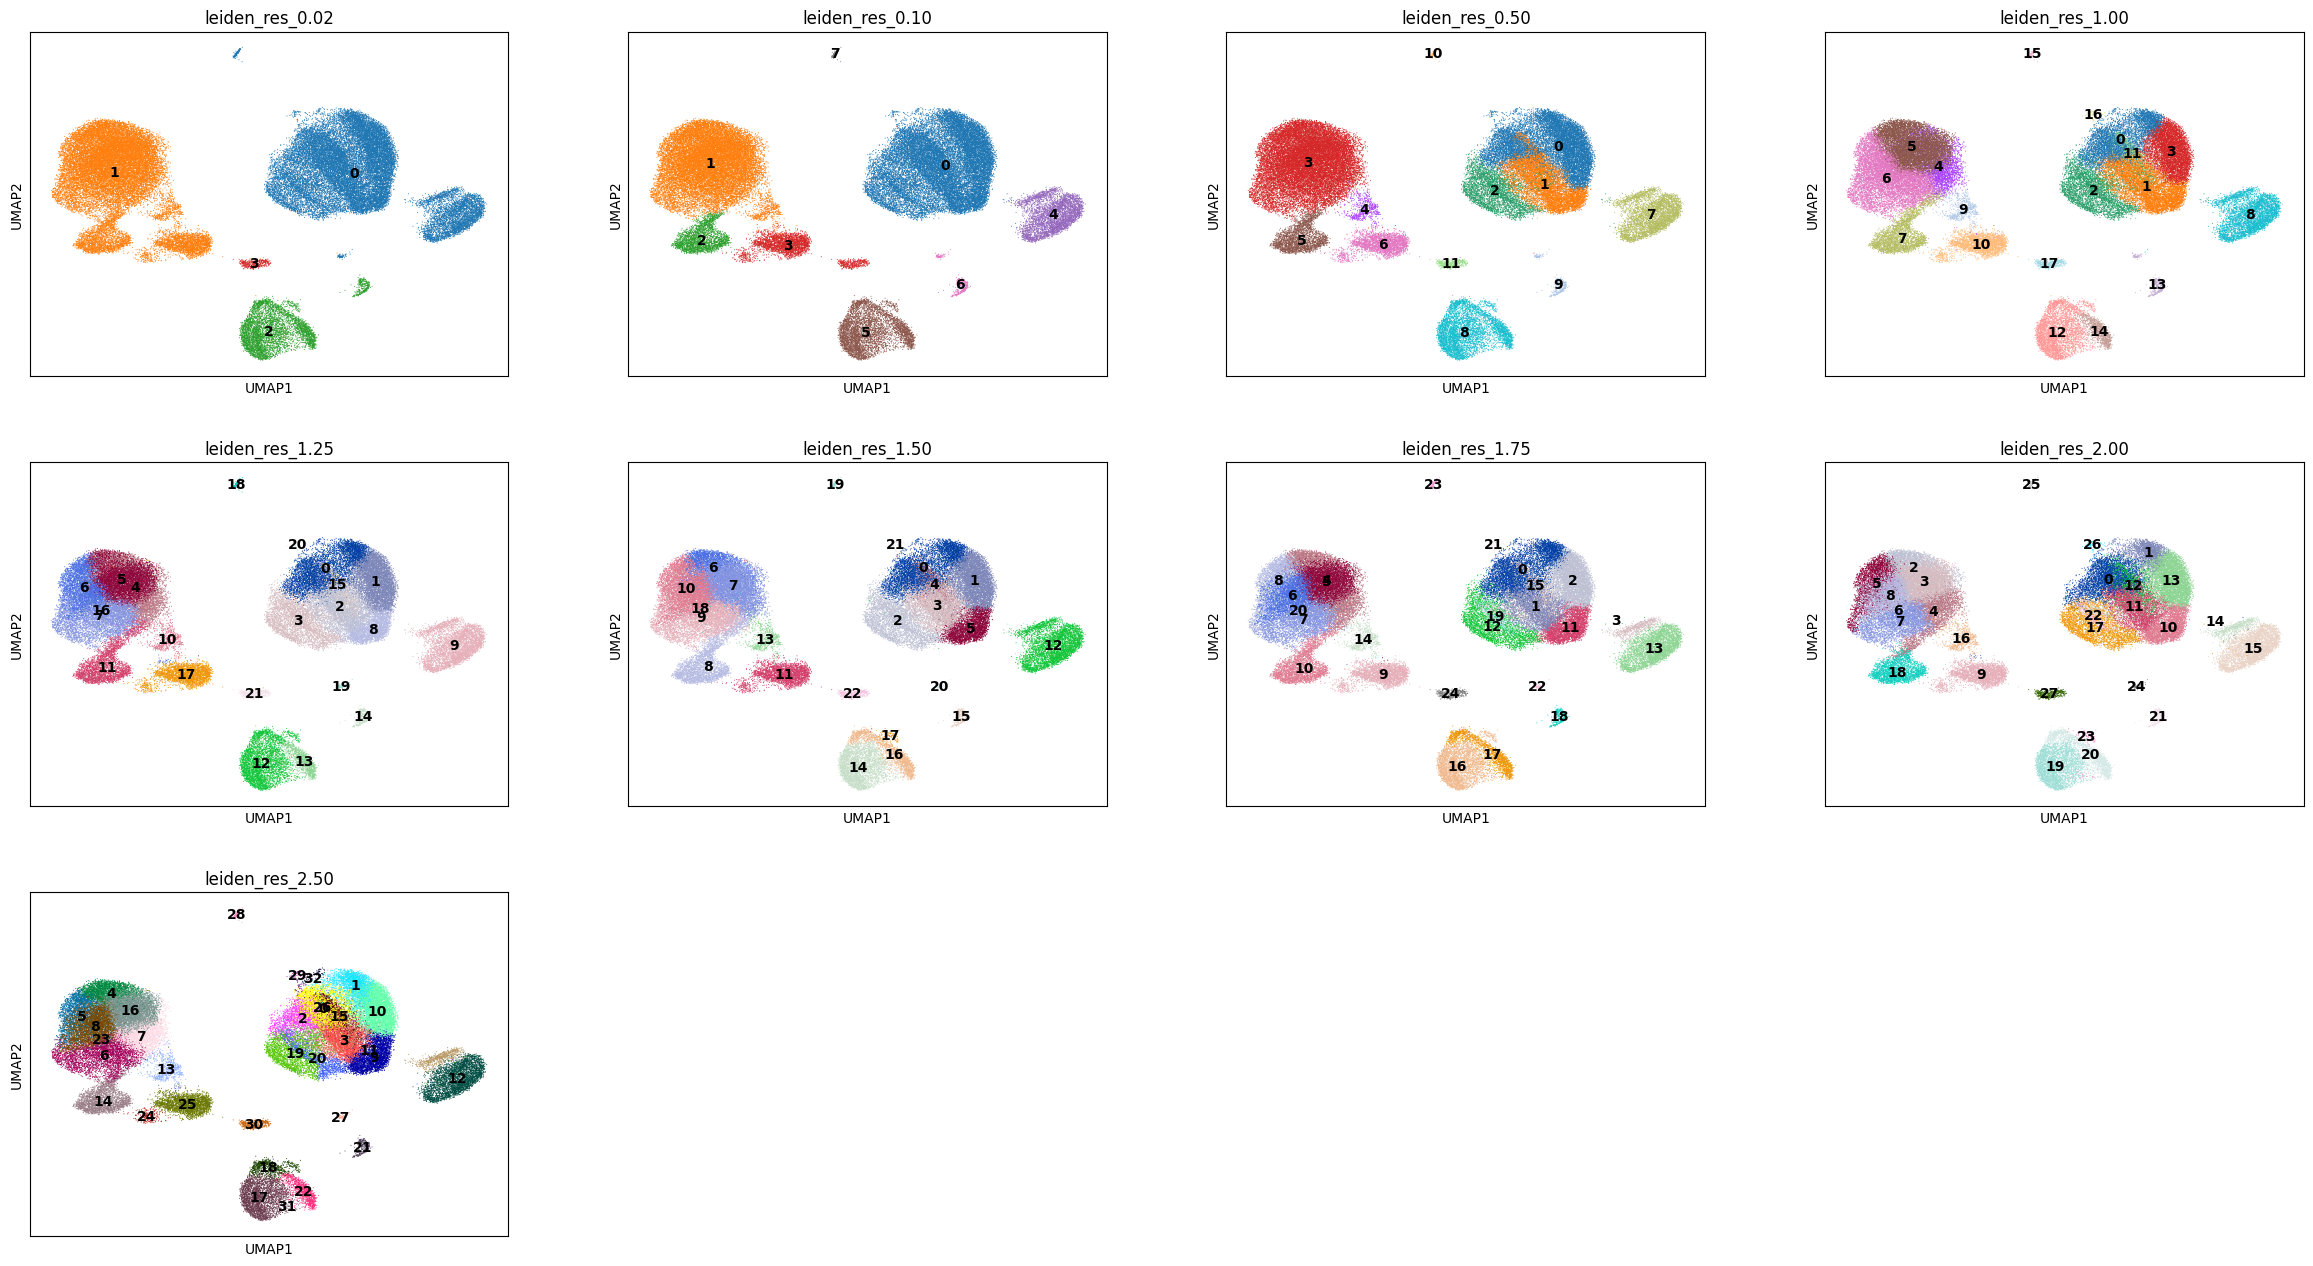

In [55]:
sc.pl.umap(
    adata,
    color=[ "leiden_res_0.02", "leiden_res_0.10", "leiden_res_0.50","leiden_res_1.00", "leiden_res_1.25","leiden_res_1.50", "leiden_res_1.75", "leiden_res_2.00", "leiden_res_2.50"],
    legend_loc="on data",
)

In [56]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4", "MKI67"],
}

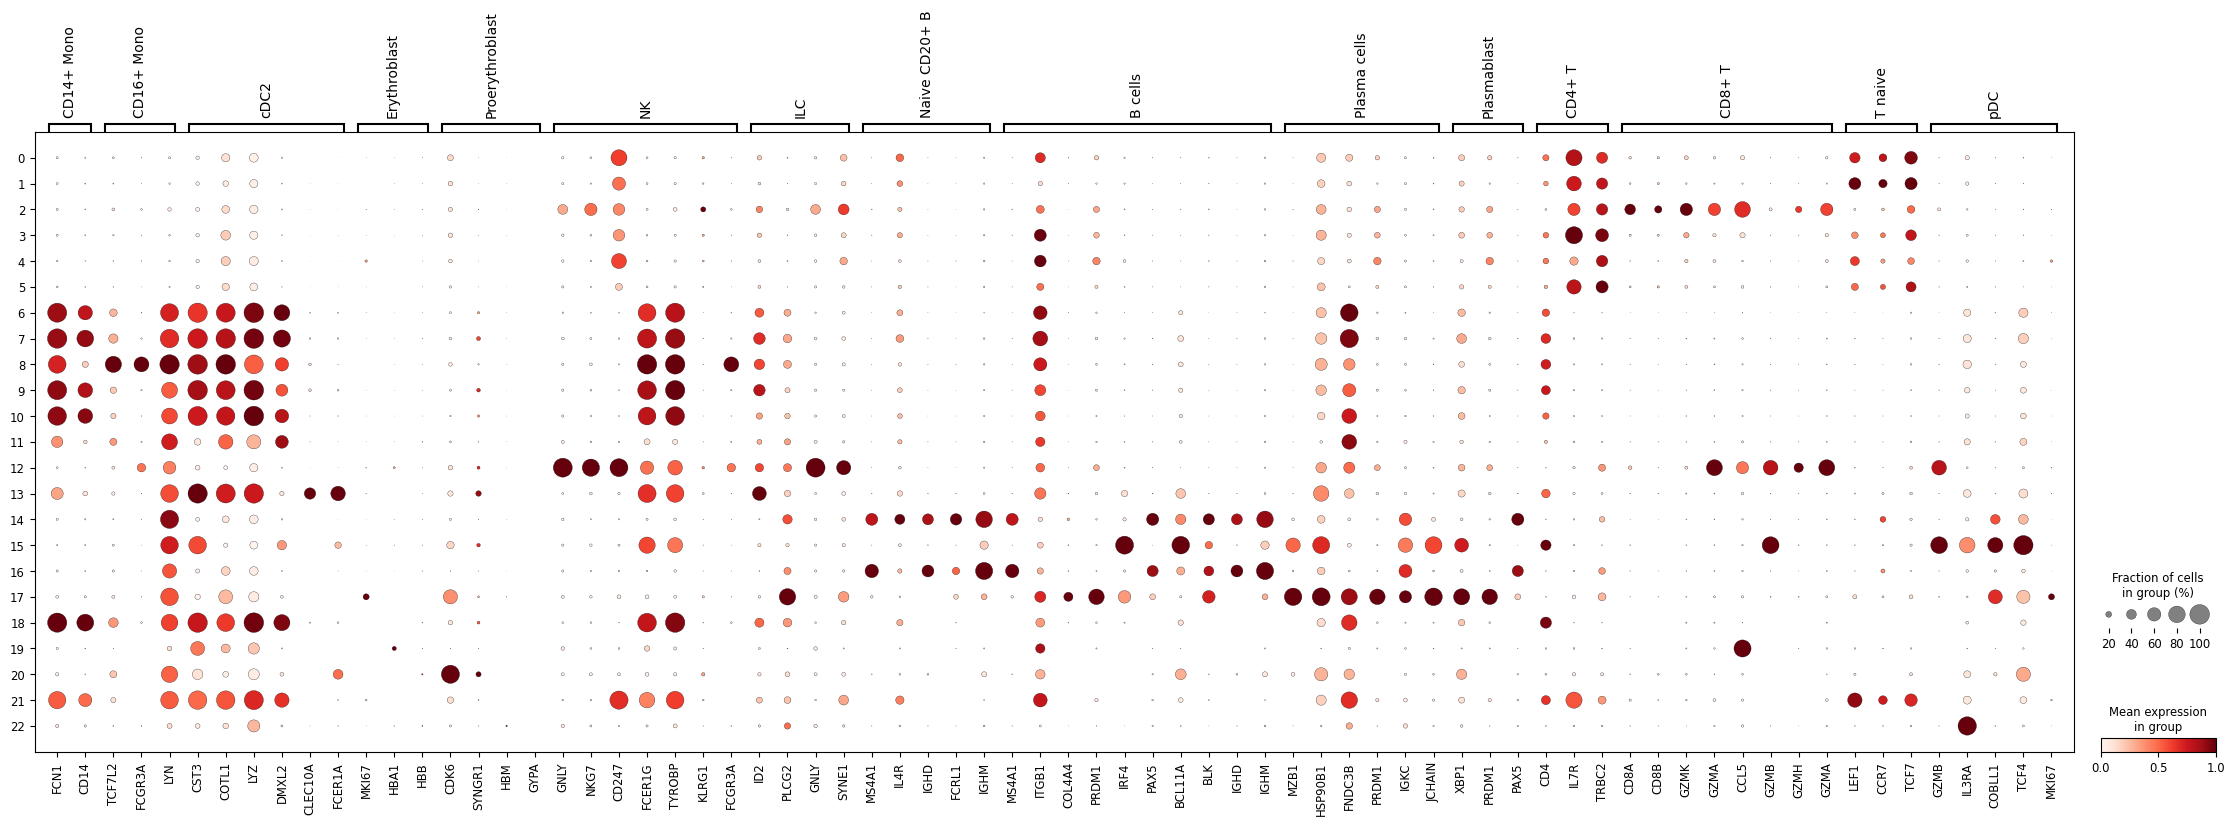

In [57]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_1.50", standard_scale="var")

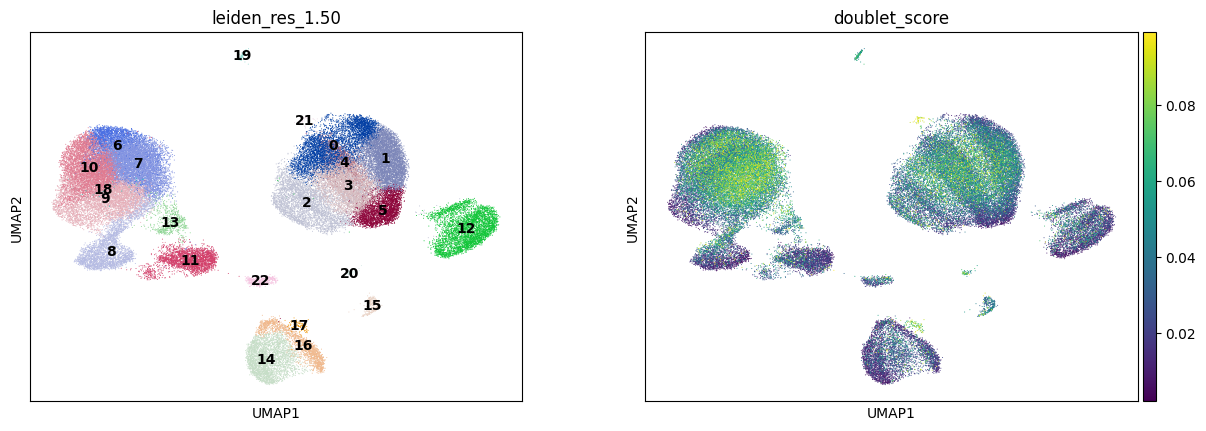

In [58]:
sc.pl.umap(
    adata,
    color=["leiden_res_1.50","doublet_score"],
    legend_loc="on data",
)

In [59]:
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_1.50"].map(
    {
        "0": "CD4+ T",
        "1": "T Naive",
        "2": "CD8+ T",
        "3": "CD4+ T",
        "4": "CD4+ T",
        "5": "CD4+ T",
        "6": "CD14+ Mono",
        "7": "CD14+ Mono",
        "8": "CD16+ Mono",
        "9": "CD14+ Mono",
        "10": "CD14+ Mono",
        "11": "CD14+ Mono",
        "12": "NK Cell",
        "13": "cDC2",
        "14": "B Naive",
        "15": "pDC",
        "16": "B Memory",
        "17": "Plasmablast",
        "18": "CD14+ Mono",
        "19": "Platelet",
        "20": "Proerythroblast",
        "21": "doublet",
        "22": "Basophil",
    }
)

# Override cluster 17
override_mask = adata.obs["leiden_res_1.50"] == "12"
adata.obs.loc[override_mask, "cell_type_lvl1"] = (
    adata.obs.loc[override_mask, "leiden_res_1.75"]
    .map({
        "3": "NKT",
        "13": "NK Cell"
    })
    .fillna(adata.obs.loc[override_mask, "cell_type_lvl1"])  # keep original if not mapped
)

# Override cluster 16
override_mask = adata.obs["leiden_res_1.50"] == "11"
adata.obs.loc[override_mask, "cell_type_lvl1"] = (
    adata.obs.loc[override_mask, "leiden_res_2.50"]
    .map({
        "25": "CD14^t Mono",
        "24": "CD16^t Mono"
    })
    .fillna(adata.obs.loc[override_mask, "cell_type_lvl1"])
)

# Override cluster 16
override_mask = adata.obs["leiden_res_1.50"] == "0"
adata.obs.loc[override_mask, "cell_type_lvl1"] = (
    adata.obs.loc[override_mask, "leiden_res_2.00"]
    .map({
        "1": "T Naive",
    })
    .fillna(adata.obs.loc[override_mask, "cell_type_lvl1"])
)

# Override cluster 16
override_mask = adata.obs["leiden_res_1.50"] == "4"
adata.obs.loc[override_mask, "cell_type_lvl1"] = (
    adata.obs.loc[override_mask, "leiden_res_2.00"]
    .map({
        "1": "T Naive",
    })
    .fillna(adata.obs.loc[override_mask, "cell_type_lvl1"])
)


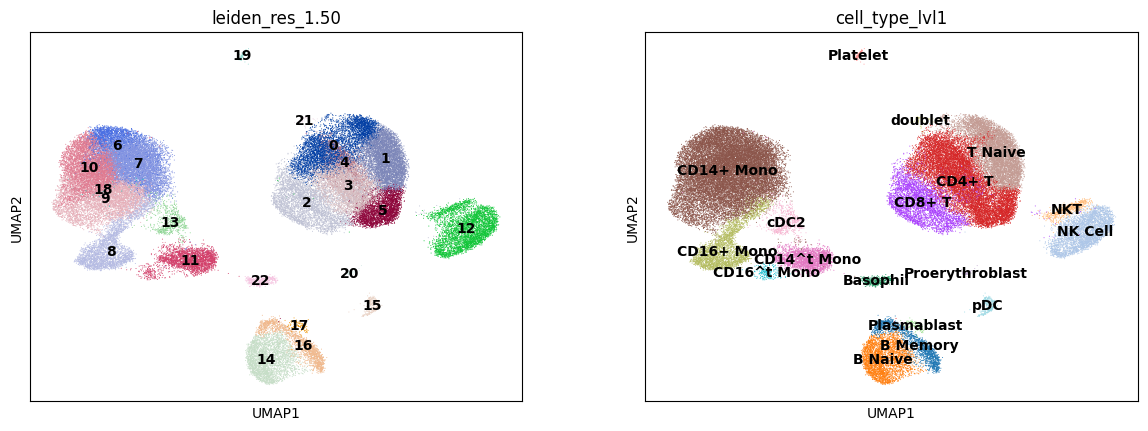

In [60]:
sc.pl.umap(
    adata,
    color=["leiden_res_1.50", "cell_type_lvl1"],
    legend_loc="on data",
)

In [61]:
adata = adata[adata.obs["cell_type_lvl1"] != "doublet"].copy()


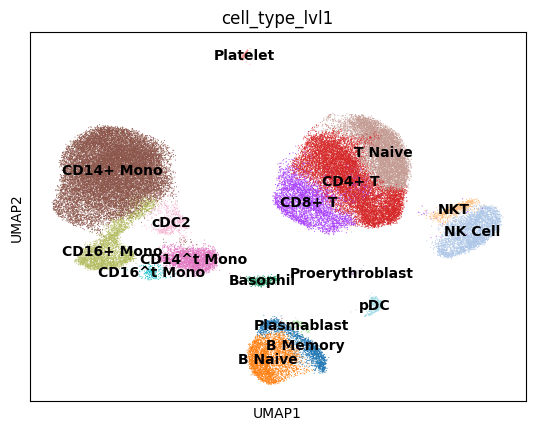

In [62]:
sc.pl.umap(
    adata,
    color=[ "cell_type_lvl1"],
    legend_loc="on data",
)

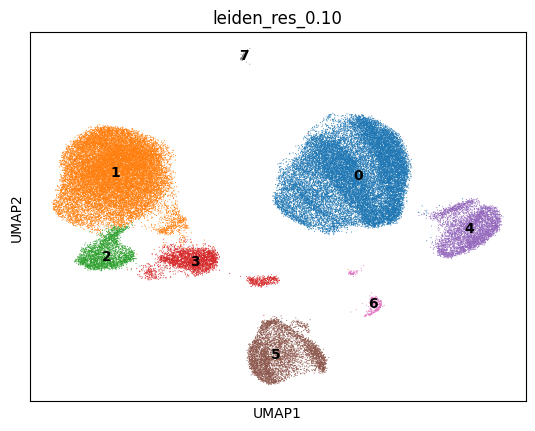

In [63]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.10"],
    legend_loc="on data",
)

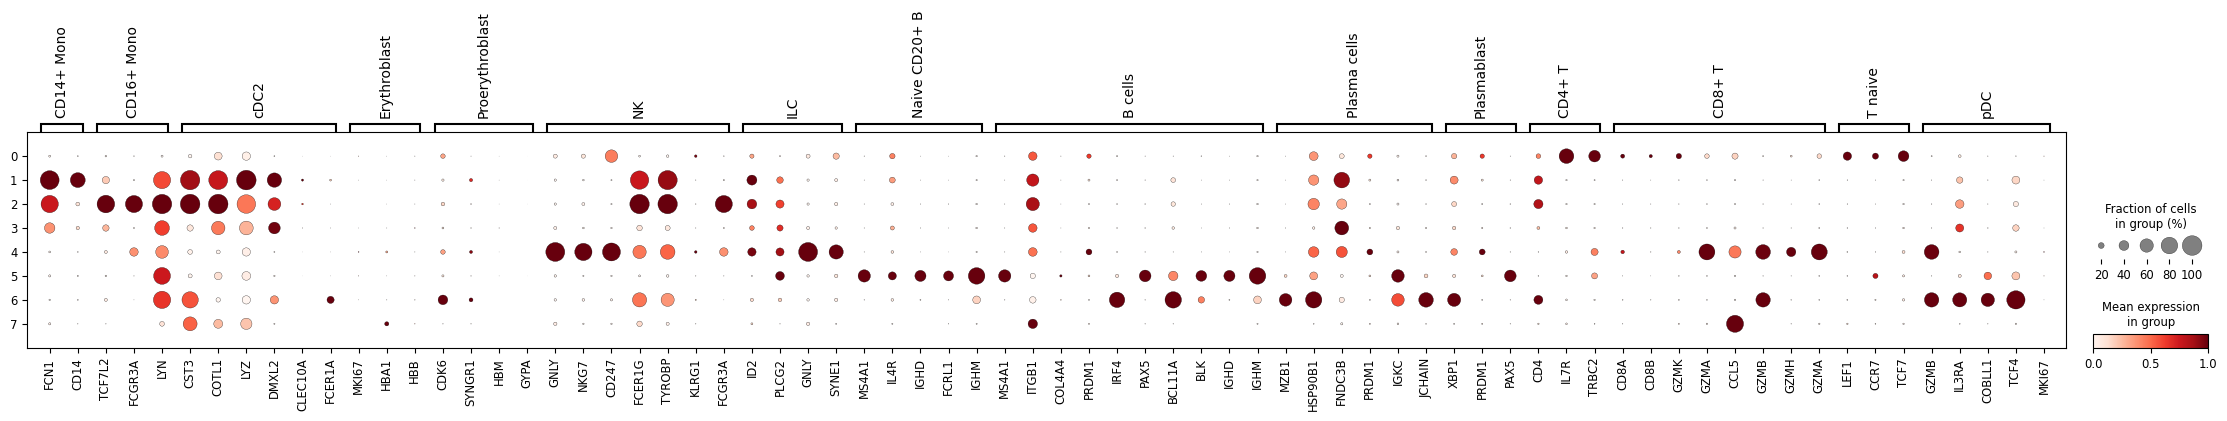

In [64]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.10", standard_scale="var")

In [65]:
adata.obs["cell_type_lvl0"] = adata.obs["leiden_res_0.10"].map(
    {
        "0": "T Cell",
        "1": "Monocyte",
        "2": "Monocyte",
        "3": "Monocyte",
        "4": "NK Cell",
        "5": "B Cell",
        "6": "Dendritic Cell",
        "7": "Platelet",
    }
)

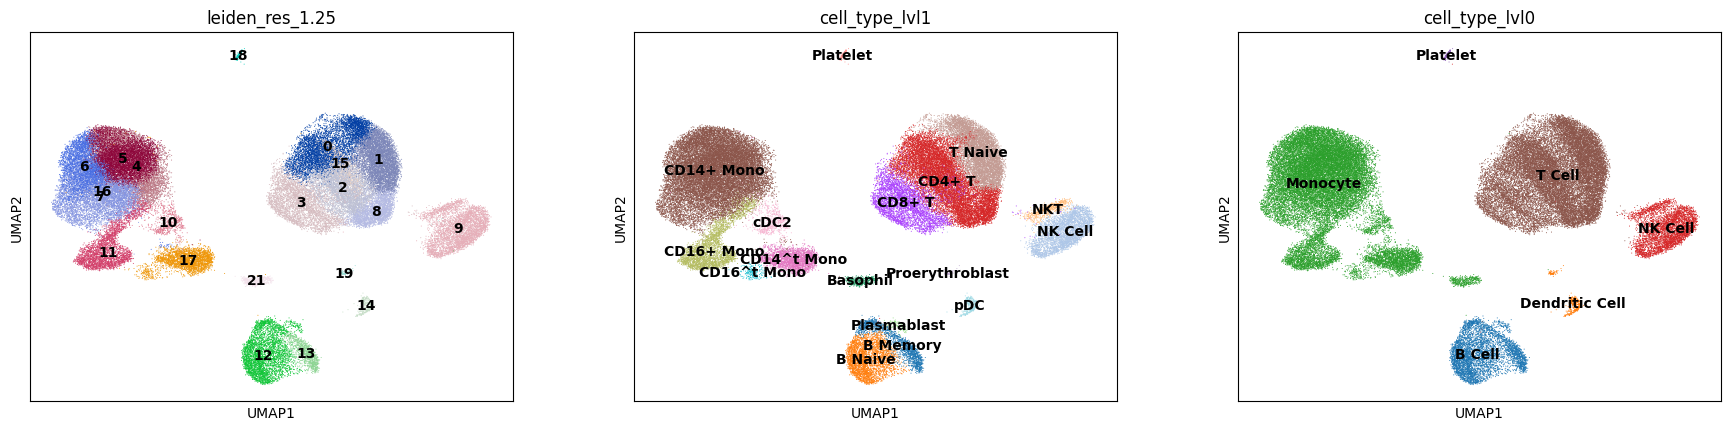

In [66]:
sc.pl.umap(
    adata,
    color=["leiden_res_1.25", "cell_type_lvl1","cell_type_lvl0"],
    legend_loc="on data",
)

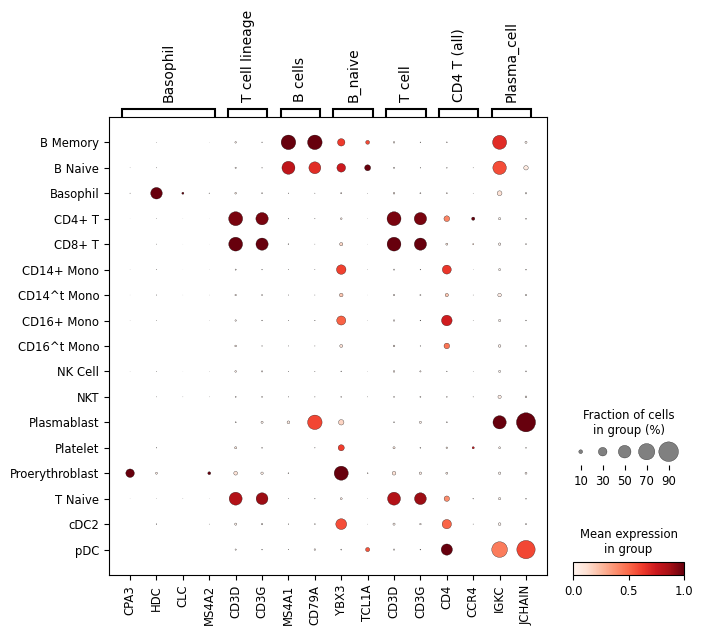

In [67]:
baso_markers = {
    'Basophil': ['CPA3', 'HDC', 'CLC', 'MS4A2'],
    'T cell lineage': ['CD3D', 'CD3G'],
    'B cells': ['MS4A1', 'CD79A'],
    'B_naive': ['YBX3', 'TCL1A'],
    'T cell': ['CD3D', 'CD3G'],
    'CD4 T (all)': ['CD4', 'CCR4'],
    'Plasma_cell': ['IGKC', 'JCHAIN'],
}
sc.pl.dotplot(adata, baso_markers, groupby="cell_type_lvl1", standard_scale="var")

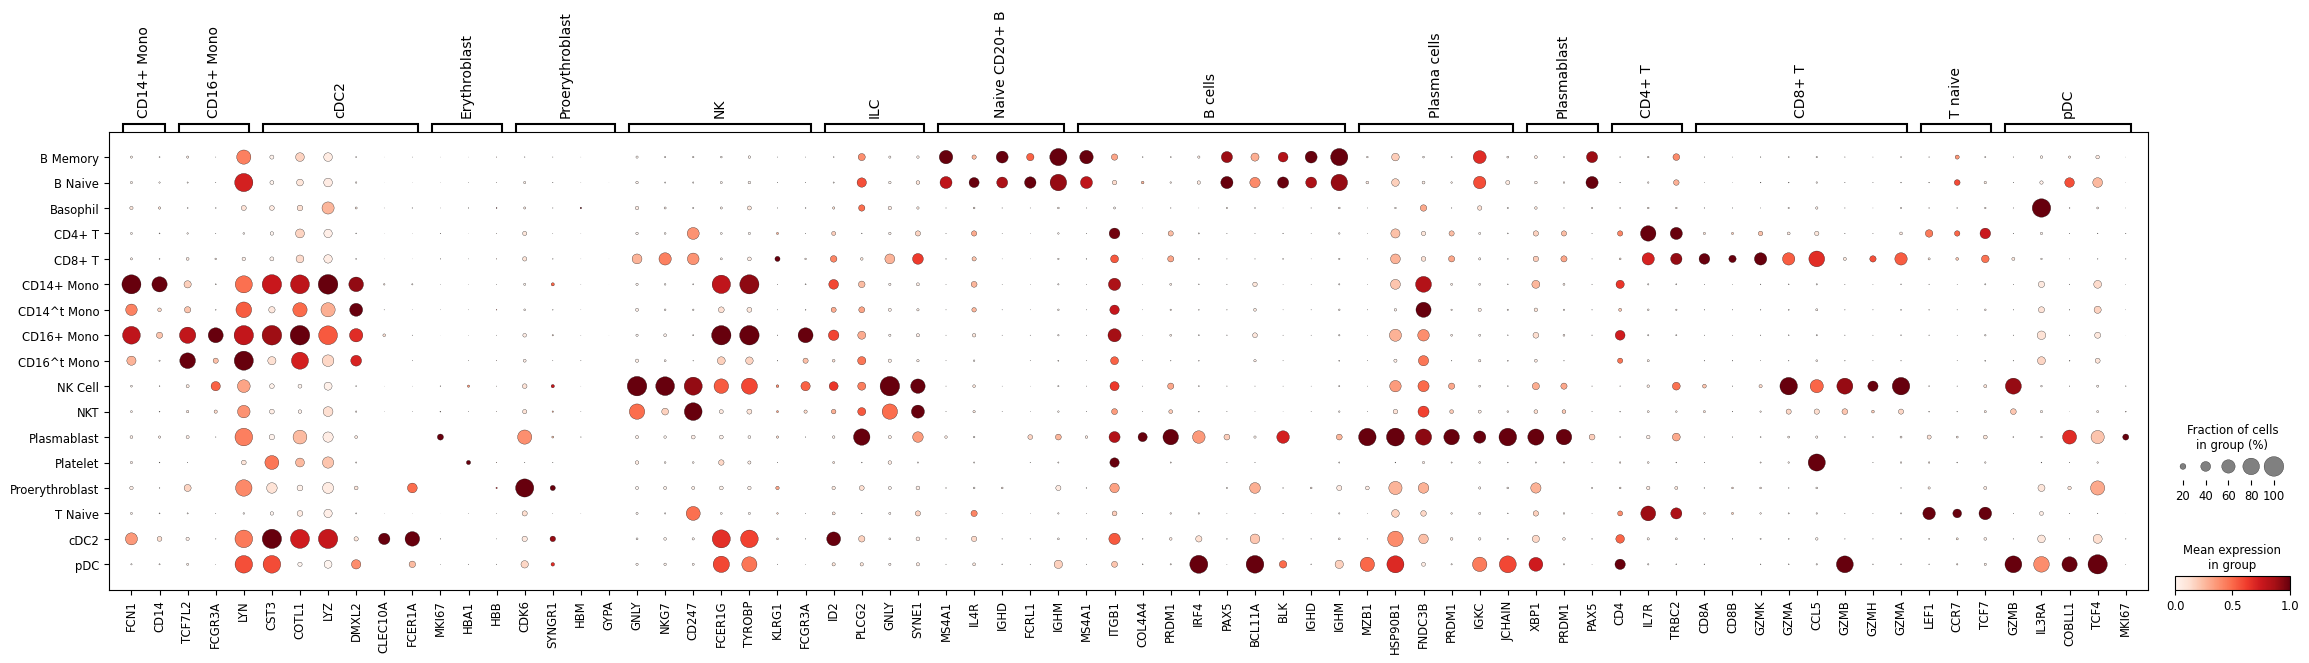

In [68]:
sc.pl.dotplot(adata, marker_genes, groupby="cell_type_lvl1", standard_scale="var")

In [69]:
adata.obs["cell_type_lvl2"] = adata.obs["cell_type_lvl1"].replace({
    "CD14^t Mono": "CD14+ Mono",
    "CD16^t Mono": "CD16+ Mono",
})

/tmp/ipykernel_27889/2642573496.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["cell_type_lvl2"] = adata.obs["cell_type_lvl1"].replace({


In [70]:
adata.write("PBMC_combined_annotated_3data.h5ad")

### Figure 2c

In [3]:
import scanpy as sc
adata = sc.read("../F2.PBMC/PBMC_combined_annotated_3data.h5ad")

In [4]:
# Define a mapping from old values to new values
source_mapping = {
    "10X-dUTSO": "10x-dUTSO",
    "SSTX": "TotalX",
    "SSTX-pA+": "TotalX(pA++)"
}

# Replace values in the 'source' column based on the mapping
adata.obs["source"] = adata.obs["source"].replace(source_mapping)


/tmp/ipykernel_19176/2695081189.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["source"] = adata.obs["source"].replace(source_mapping)


/tmp/ipykernel_19176/1441508341.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['cell_type_lvl2', 'source'])
/tmp/ipykernel_19176/1441508341.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


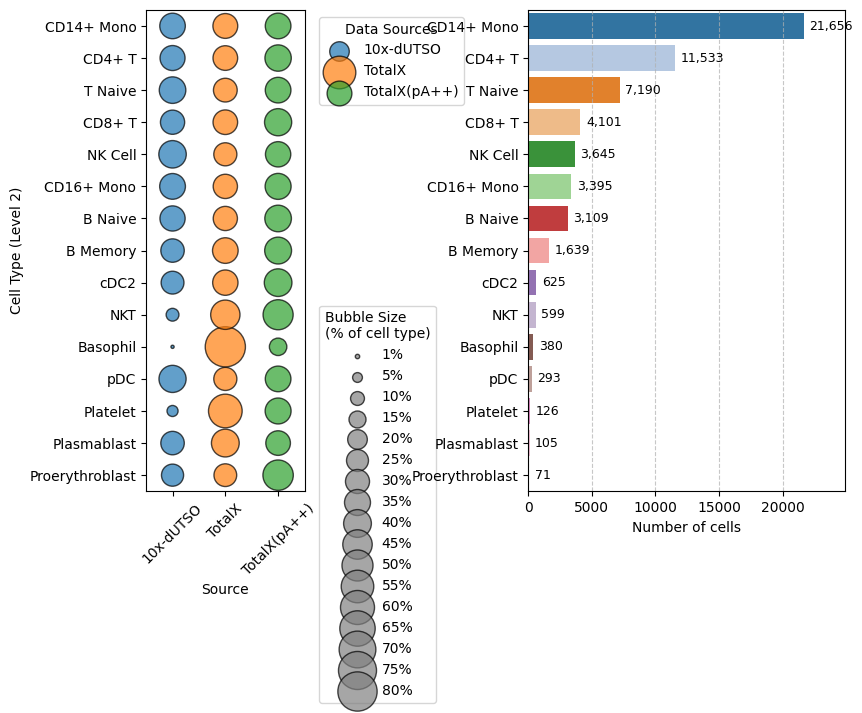

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D  # For custom legend items

import seaborn as sns
# If you want to use the same order as before (most abundant → least)
plot_order = adata.obs['cell_type_lvl2'].value_counts().index.tolist()
# Use the same palette as in the original barplot
celltype_palette = sns.color_palette("tab20", n_colors=len(plot_order))

# Map cell types to colors
celltype_color_dict = dict(zip(plot_order, celltype_palette))


# 1. Get ground truth order
total_per_cell_type = adata.obs['cell_type_lvl2'].value_counts()
ground_truth_order = total_per_cell_type.index.tolist()
plot_order = ground_truth_order[::-1]  # Reverse for correct visual ordering

# 2. Prepare bubble data
bubble_data = (
    adata.obs.groupby(['cell_type_lvl2', 'source'])
    .size()
    .unstack(fill_value=0)
    .reindex(plot_order)
    .stack()
    .reset_index(name='count')
)
cell_type_totals = bubble_data.groupby('cell_type_lvl2')['count'].transform('sum')
bubble_data['percent'] = (bubble_data['count'] / cell_type_totals) * 100
bubble_data['y_pos'] = bubble_data['cell_type_lvl2'].map({ct: idx for idx, ct in enumerate(plot_order)})

# 3. Create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [1, 2]})

# Color palette
sources = bubble_data['source'].unique()
source_colors = sns.color_palette('tab10', len(sources))
source_palette = dict(zip(sources, source_colors))

# LEFT PLOT - BUBBLE
# -----------------------------------
for source, color in source_palette.items():
    subset = bubble_data[bubble_data['source'] == source]
    axes[0].scatter(
        x=subset['source'],
        y=subset['y_pos'],
        s=subset['percent'] * 10,
        color=color,
        alpha=0.7,
        edgecolor='k',
        label=source
    )

# Set axis properties
axes[0].set_yticks(range(len(plot_order)))
axes[0].set_yticklabels(plot_order)
axes[0].set_ylim(-0.5, len(plot_order)-0.5)
axes[0].set_ylabel('Cell Type (Level 2)')
axes[0].set_xlabel('Source')

# RIGHT PLOT - BAR
# -------------------------------
bar_data = pd.DataFrame({
    'cell_type': plot_order,
    'count': total_per_cell_type[plot_order].values
})

# Previous code remains the same until the bar plot section...

# RIGHT PLOT - BAR (with numbers)
# -------------------------------
barplot = sns.barplot(
    data=bar_data,
    y='cell_type',
    x='count',
    palette=celltype_color_dict,
    ax=axes[1],
    order=plot_order
)

# Add text labels for each bar
for i, (cell_type, count) in enumerate(zip(plot_order, total_per_cell_type[plot_order])):
    axes[1].text(
        x=count + (0.02 * max(total_per_cell_type)),  # Small offset from bar
        y=i,  # Same y-position as the bar
        s=f'{count:,}',  # Format with thousands separator
        va='center',  # Vertical alignment
        ha='left',    # Horizontal alignment
        fontsize=9
    )

# Adjust x-axis limit to accommodate text labels
axes[1].set_xlim(right=max(total_per_cell_type) * 1.15)  # 15% extra space

# Rest of the code (legends, etc.) remains the same...
axes[1].set_ylim(-0.5, len(plot_order)-0.5)
axes[1].set_xlabel('Number of cells')
axes[1].set_ylabel('')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

# ========== LEGEND ADDITIONS ==========

# 1. SOURCE LEGEND (for bubble colors)
source_legend = axes[0].legend(
    title='Data Sources',
    bbox_to_anchor=(1.05, 1),  # Positions outside the plot
    loc='upper left',
    frameon=True
)

# 2. BUBBLE SIZE LEGEND (for percentages)
# Create dummy invisible points for legend
# After creating the bubble plot, replace the legend code with:

# 1. Calculate 10%-rounded sizes
max_percent = bubble_data['percent'].max()
size_range = [1] + list(np.arange(5, min(100, np.ceil(max_percent/5)*5 + 5), 5))  # 1%, then 5,10,15...
size_range = [x for x in size_range if x <= max_percent]  # Filter to actual data range


# 2. Create legend
size_legend_elements = [
    plt.scatter([], [],
                s=(size * 10),
                c='gray',
                edgecolor='k',
                alpha=0.7,
                label=f'{int(size)}%')
    for size in sorted(size_range)
]

# 3. Add to plot
size_legend = axes[0].legend(
    handles=size_legend_elements,
    title='Bubble Size\n(% of cell type)',
    bbox_to_anchor=(1.05, 0.4),
    loc='upper left',
    frameon=True
)
axes[0].add_artist(source_legend)  # Keep source legend
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].set_xlim(-0.5, len(sources) - 0.5)  # or +0.3 if needed

# 3. BAR PLOT LEGEND (for cell type colors, if needed)
# Only add if you have meaningful color mapping in barplot
# Otherwise the y-axis labels already show cell types

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make space for legends
#plt.savefig("cell_type_bubble_barplot_celltype_lvl2.pdf", format="pdf", bbox_inches="tight")
plt.show()

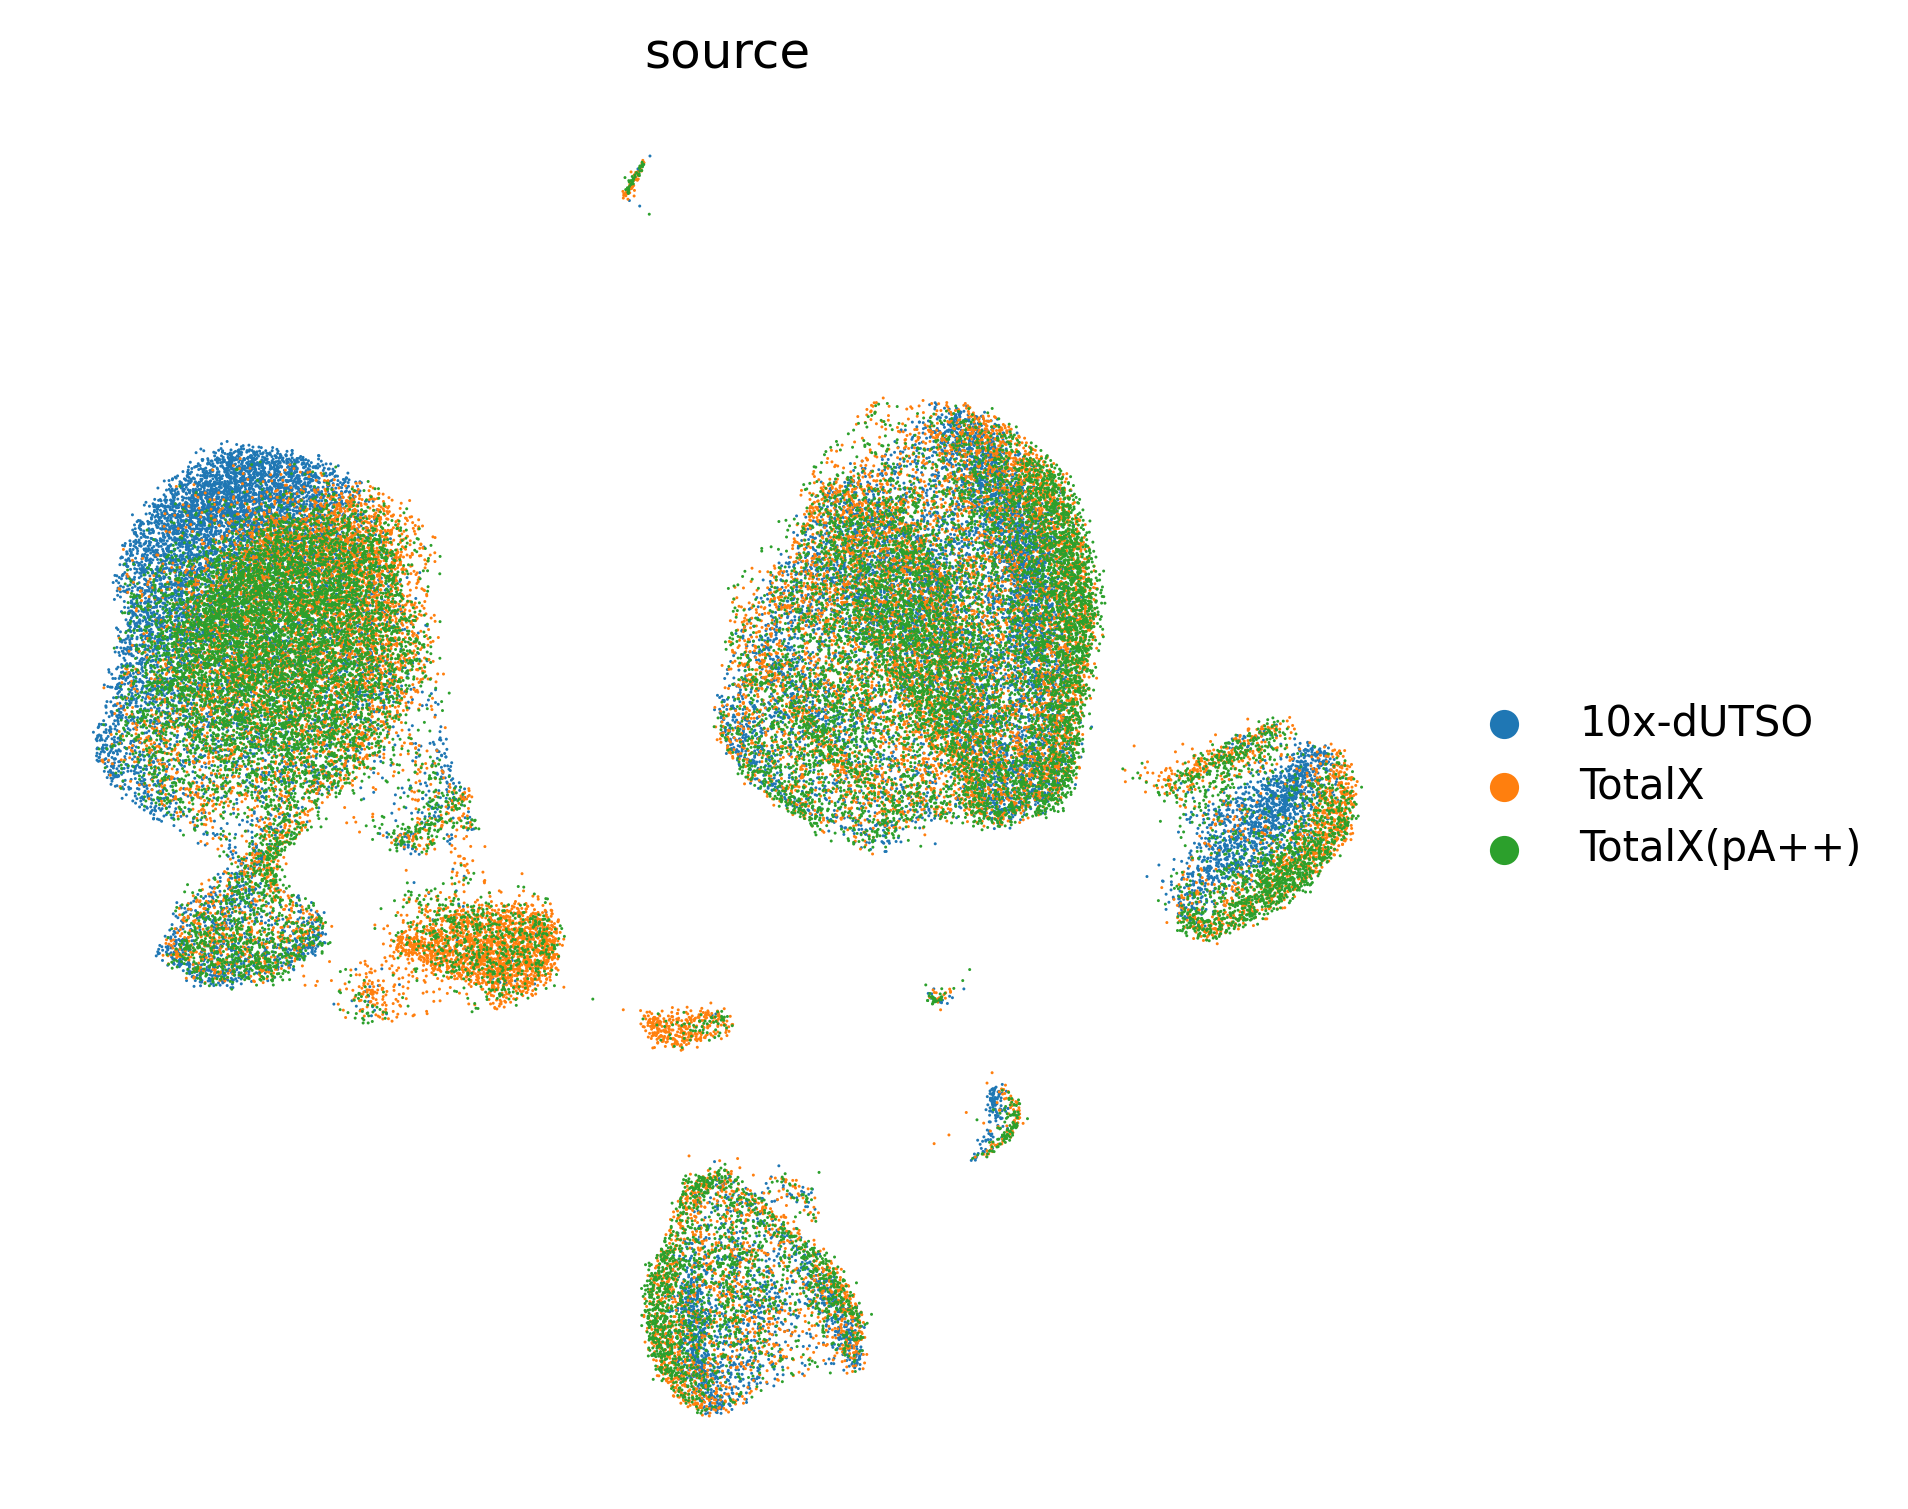

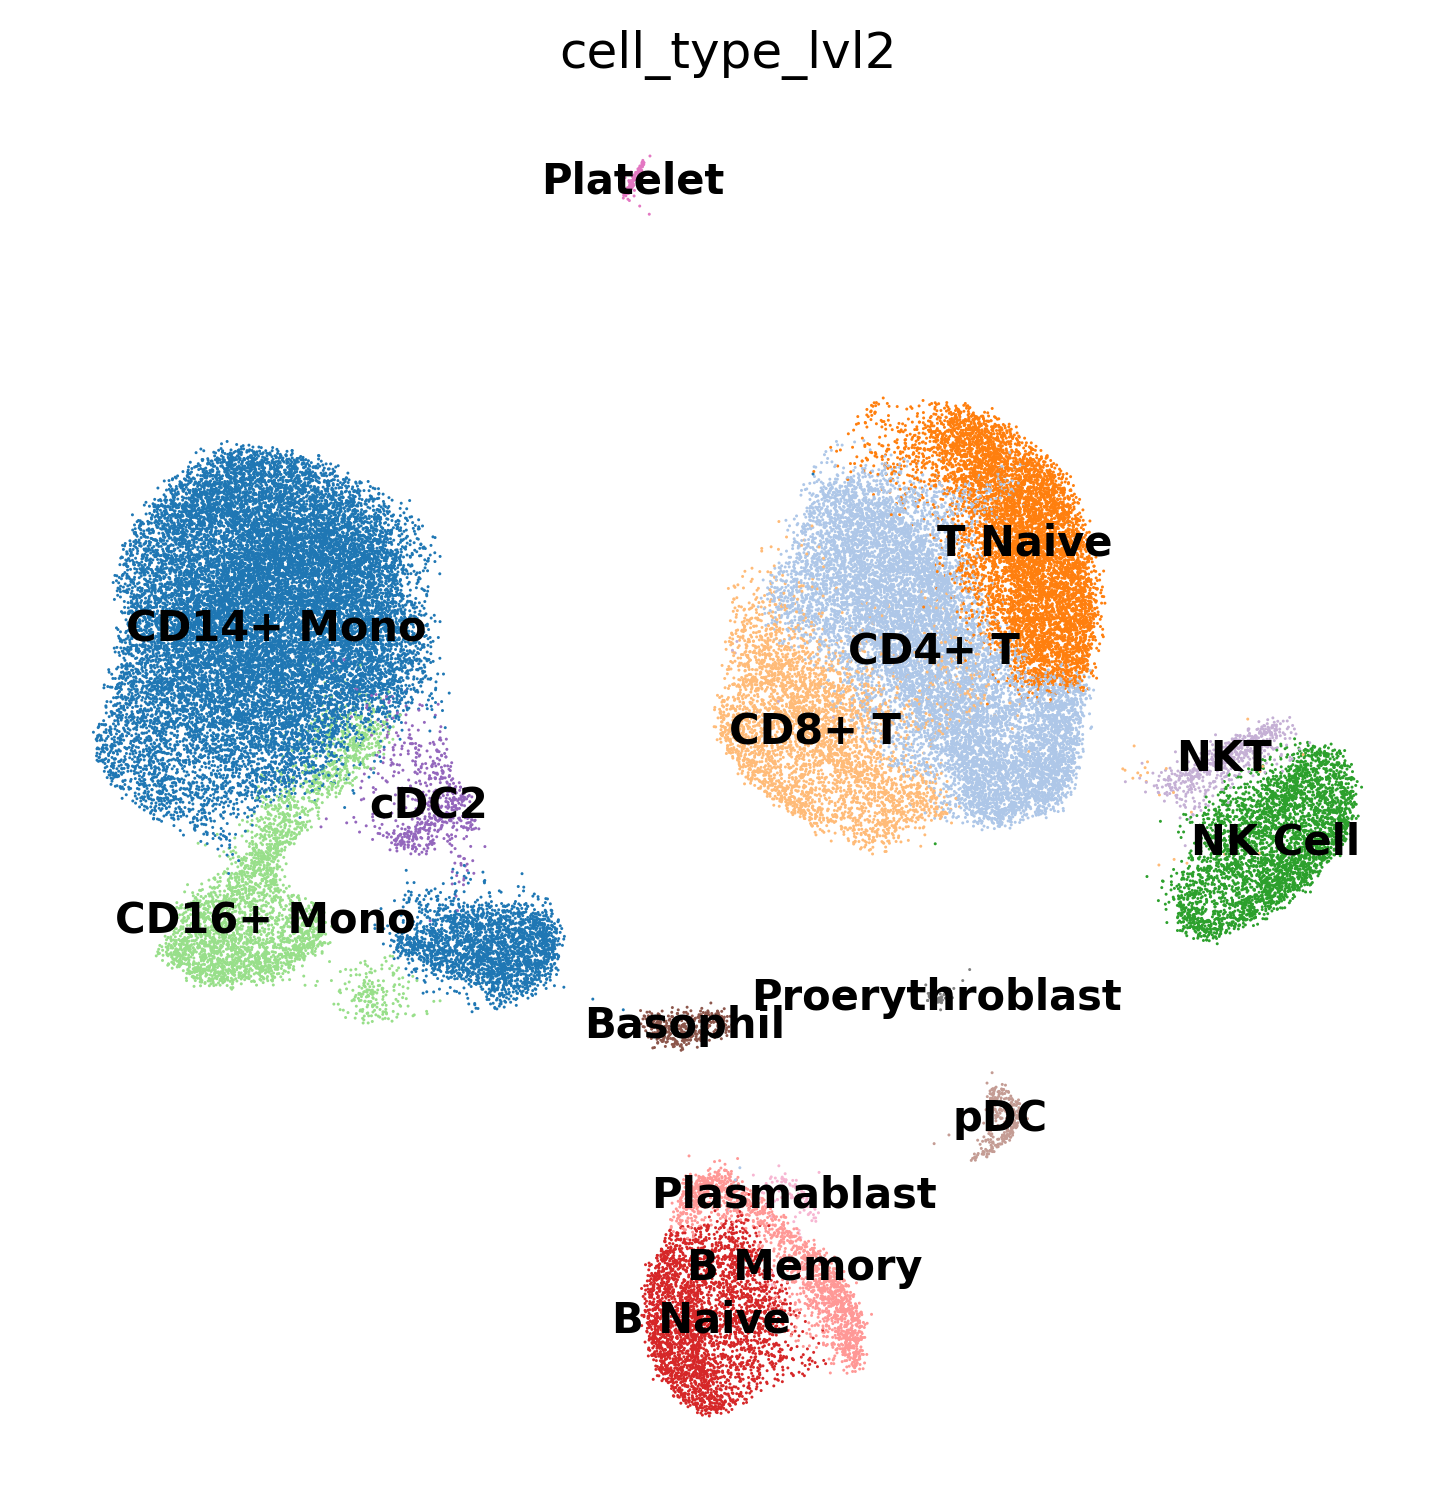

In [6]:
with plt.rc_context({"figure.figsize": (6, 6), "figure.dpi": 300}):
    sc.pl.umap(
        adata,
        color="source",
        frameon=False,
    )
    sc.pl.umap(
        adata,
        color="cell_type_lvl2",
        palette=celltype_color_dict,
        legend_loc="on data",  # or "right margin"
        frameon=False,
    )


### Marker gene figure

/tmp/ipykernel_19176/3526362436.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


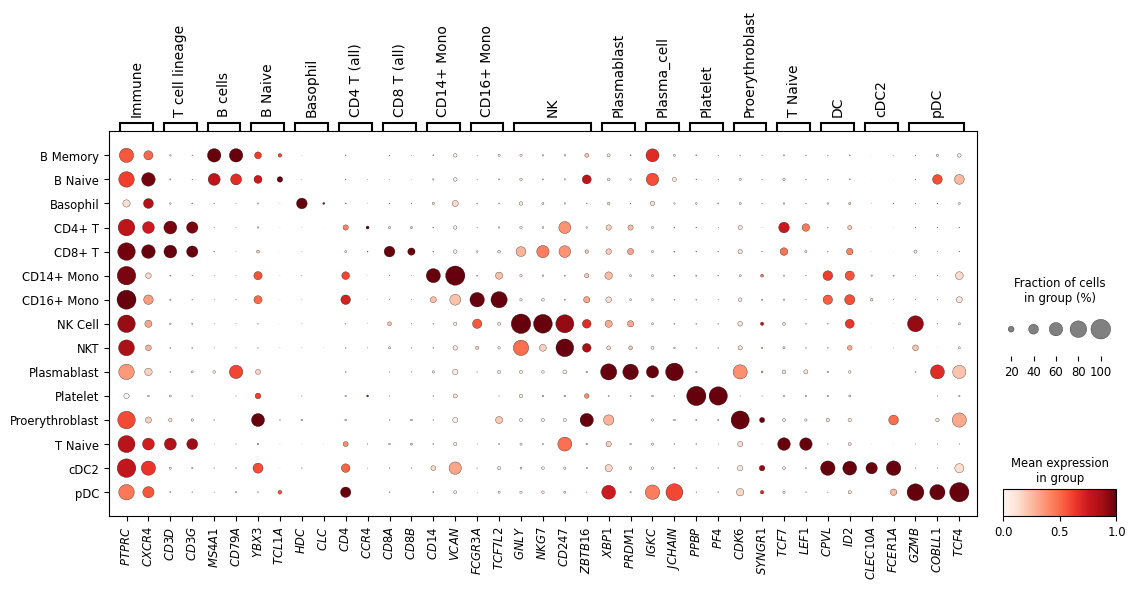

In [7]:
marker_genes = {
    'Immune': ['PTPRC', 'CXCR4'],
    'T cell lineage': ['CD3D', 'CD3G'],
    'B cells': ['MS4A1', 'CD79A'],
    "B Naive": ['YBX3', 'TCL1A'],
    "Basophil": [
        "HDC",
        "CLC",
    ],
    'CD4 T (all)': ['CD4', 'CCR4'],
    'CD8 T (all)': ['CD8A', 'CD8B'],
    "CD14+ Mono": ["CD14","VCAN"],
    "CD16+ Mono": ["FCGR3A","TCF7L2"],
    # Note: DMXL2 should be negative
    "NK": ["GNLY", "NKG7", "CD247", 'ZBTB16'],
    "Plasmablast": ["XBP1", "PRDM1"],
    'Plasma_cell': ['IGKC', 'JCHAIN'],
    "Platelet": ["PPBP", "PF4"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1"],
    
    "T Naive": ["TCF7", "LEF1"],
    'DC': ['CPVL', 'ID2'],
    "cDC2": ["CLEC10A", "FCER1A"],
    "pDC": ["GZMB", "COBLL1", "TCF4"],
    
    # Note PAX5 is a negative marker
    
}
dp = sc.pl.dotplot(adata, marker_genes, 
   groupby="cell_type_lvl2", 
   standard_scale="var",
   show=False,
   figsize=(13,5))

# Get the correct axis
ax = dp['mainplot_ax']
gene_list = []
for group in marker_genes.values():
    gene_list.extend(group)

genes_italic = [r"$\mathit{{{}}}$".format(g) for g in gene_list]
ax.set_xticklabels(genes_italic, rotation=90)

plt.tight_layout()
plt.show()

### DEGs

In [ ]:
adata = adata[adata.obs['source'] == 'SSTX'].copy()


# Count in how many cells each gene is expressed
gene_counts = np.asarray((adata.X > 0).sum(axis=0)).flatten()

# Filter genes expressed in at least 3 cells
is_expressed = gene_counts >= 3

# Get biotype info
biotypes = adata.var["biotype"]

# Get biotypes for expressed genes
biotypes_expressed = biotypes[is_expressed]

# Count number of expressed genes per biotype
biotype_counts = biotypes_expressed.value_counts().sort_values(ascending=False)

# Convert to DataFrame
df_biotype_counts = biotype_counts.reset_index()
df_biotype_counts.columns = ["Biotype", "Number of Expressed Genes"]

# Plot with log-scale y-axis
plt.figure(figsize=(10, 6))
sns.barplot(data=df_biotype_counts, x="Biotype", y="Number of Expressed Genes", palette="tab20")
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.title("Number of Genes Expressed in ≥3 Cells per Biotype (Log Scale)")
plt.tight_layout()
plt.show()




# Define colors for biotypes
biotype_colors = {
    'lncRNA': '#1f77b4',
    'misc_RNA': '#ff7f0e',
    'miRNA': '#2ca02c',
    'snoRNA': '#d62728',
    'tRNA': '#9467bd',
    'scaRNA': '#8c564b',
    'snRNA': '#e377c2',
    'histone_RNA': '#17BECF',
    'protein_coding': '#7c7c7f'
}

# Choose biotypes of interest
target_biotypes = ["lncRNA", "misc_RNA", "miRNA", "snoRNA", "tRNA", "snRNA", "histone_RNA", "protein_coding"]

def calculate_detected_genes_per_biotype(adata, biotype_col='biotype', target_biotypes=None):
    if biotype_col not in adata.var.columns:
        raise ValueError(f"'{biotype_col}' column not found in adata.var")
    
    adata.obs.index = adata.obs.index.astype(str)
    adata.var.index = adata.var.index.astype(str)

    # Binary detection matrix
    detected = (adata.X > 0).astype(int) if not issparse(adata.X) else adata.X.copy()
    if issparse(detected):
        detected.data = np.where(detected.data > 0, 1, 0)

    gene_counts = {}
    for biotype in target_biotypes:
        gene_mask = (adata.var[biotype_col] == biotype).to_numpy()
        col_idx = np.nonzero(gene_mask)[0]

        if len(col_idx) == 0:
            gene_counts[biotype] = np.zeros(adata.n_obs)
        else:
            col_data = detected[:, col_idx].sum(axis=1)
            # Convert result to 1D NumPy array
            if hasattr(col_data, "A1"):  # common for sparse matrix result
                gene_counts[biotype] = col_data.A1
            else:
                gene_counts[biotype] = np.asarray(col_data).ravel()

    return pd.DataFrame(gene_counts, index=adata.obs.index)



# Compute detected genes per cell per biotype
gene_counts = calculate_detected_genes_per_biotype(adata, biotype_col='biotype', target_biotypes=target_biotypes)

# Compute average across all cells
avg_detected_genes = gene_counts.mean(axis=0)
avg_detected_genes = avg_detected_genes.reindex(target_biotypes)

# Plot
plt.figure(figsize=(10, 5))
ax = avg_detected_genes.plot(kind='bar', color=[biotype_colors.get(b, '#888888') for b in avg_detected_genes.index])

plt.ylabel('Average Number of Genes Detected per Cell')
plt.xlabel('Biotype')
plt.title('Detected Genes per Cell by Biotype')
plt.yscale('log')
plt.tight_layout()
plt.show()


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Run DE analysis
sc.tl.rank_genes_groups(
    adata,
    groupby="cell_type_lvl2",
    method="wilcoxon",
    pts=True
)

# Step 2: Collect significant DEGs and annotate with biotype
p_thresh = 0.01
biotypes = adata.var["biotype"]

results = []

groups = adata.uns["rank_genes_groups"]["names"].dtype.names
for group in groups:
    names = adata.uns["rank_genes_groups"]["names"][group]
    pvals = adata.uns["rank_genes_groups"]["pvals_adj"][group]
    
    for gene, p in zip(names, pvals):
        if p < p_thresh and gene in biotypes.index:
            bio = biotypes[gene]
            if bio in target_biotypes:
                results.append({
                    "cell_type": group,
                    "gene": gene,
                    "biotype": bio
                })

df_degs = pd.DataFrame(results)

# Step 3: Summarize number of DEGs per biotype per cell type
df_summary = (
    df_degs
    .groupby(["cell_type", "biotype"])
    .size()
    .reset_index(name="n_genes")
    .pivot(index="cell_type", columns="biotype", values="n_genes")
    .fillna(0)
)

# Step 4: Prepare long-form data
df_long = df_summary.reset_index().melt(id_vars="cell_type", var_name="biotype", value_name="n_genes")
df_long["log_genes"] = np.log10(df_long["n_genes"] + 1)

# Optional: re-order biotypes
df_long["biotype"] = pd.Categorical(df_long["biotype"], categories=target_biotypes, ordered=True)



In [ ]:
# Step 2: Collect significant DEGs with p_adj < 0.05 and logFC > 1 (or 0.5, optional)
p_thresh = 0.05
logfc_thresh = 1 #0.5

biotypes = adata.var["biotype"]
results = []

groups = adata.uns["rank_genes_groups"]["names"].dtype.names

for group in groups:
    names = adata.uns["rank_genes_groups"]["names"][group]
    pvals = adata.uns["rank_genes_groups"]["pvals_adj"][group]
    logfc = adata.uns["rank_genes_groups"]["logfoldchanges"][group]
    
    for gene, p, lfc in zip(names, pvals, logfc):
        if p < p_thresh and lfc > logfc_thresh and gene in biotypes.index:
            bio = biotypes[gene]
            if bio in target_biotypes:
                results.append({
                    "cell_type": group,
                    "gene": gene,
                    "biotype": bio,
                    "logFC": lfc,
                    "p_adj": p
                })

df_degs = pd.DataFrame(results)


In [ ]:
import seaborn as sns

df_long["cell_type"] = pd.Categorical(
    df_long["cell_type"],
    categories=list(reversed(df_long["cell_type"].unique())),
    ordered=True
)

# If you want to use the same order as before (most abundant → least)
plot_order = adata.obs['cell_type_lvl2'].value_counts().index.tolist()
# Use the same palette as in the original barplot
celltype_palette = sns.color_palette("tab20", n_colors=len(plot_order))

# Map cell types to colors
celltype_color_dict = dict(zip(plot_order, celltype_palette))

g = sns.catplot(
    data=df_long,
    kind="bar",
    y="cell_type",
    x="n_genes",
    col="biotype",
    col_wrap=None,             # No wrapping = all in one row
    height=4,
    aspect=1.2,
    sharey=True,
    sharex=False,              # Let each panel scale independently
    palette=celltype_color_dict,
    orient="h"
)

# Customize labels and layout
g.set_titles("{col_name}")
g.set_axis_labels("", "Cell type")
g.set(ylim=(-0.5, len(df_long['cell_type'].unique()) - 0.5))
for ax in g.axes.flat:
    ax.tick_params(axis='y', labelrotation=0)
g.fig.text(0.5, -0.01, "Number of DEGs", ha="center", fontsize=10) 

# Adjust figure size and spacing
g.fig.set_size_inches(1.2 * len(target_biotypes), 5)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Cell-type specific DEGs by biotype (log2(FC) > 1, FDR < 0.05)", fontsize=14)
plt.tight_layout()
plt.savefig("DEGs_by_cell_type_v1.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

# Your gene list by RNA class
markers_of_interest = {
    "lncRNA": ["CHASERR","LINC00926","LINC00861","PELATON","LINC00299","CYTOR","CYTOR"],
    "histone_RNA": ["H3C2", "H1-0",   "H1-2", "H2AZ1","H2AZ1","H2AZ1","H2AZ1"],
    "miRNA":  ["MIR320A","MIR150","MIR223","MIR142","MIR650","MIR21","MIR191","MIR147B" ], #"MIR98","MIR222",
    "scaRNA": ["SCARNA7", "SCARNA5", "SCARNA6","SCARNA6","SCARNA6","SCARNA6","SCARNA6"],
    "snoRNA": ["SNORD13","SNORD35B","SNORD3A","SNORA80E","SNORA69","SNORA69","SNORA69"], #"SNORA13","SNORA74A"
    "snRNA":  ["RNVU1-28", "RNU6-2","RNY3","RNU6-2","RNU6-2","RNU6-2","RNU6-2"],
    
    
}

# Set unique color maps for each RNA class
colormaps = {
    "miRNA": "PuRd",
    "snoRNA": "Oranges",
    "lncRNA": "Blues",
    "snRNA": "YlOrBr",
    "scaRNA": "pink_r",
    "histone_RNA": "Purples"
}

rna_classes = list(markers_of_interest.keys())
n_classes = len(rna_classes)
widths = [len(markers_of_interest[rna_class]) * 0.9 for rna_class in rna_classes]  # scale factor can be adjusted
# Create subplots
fig, axes = plt.subplots(1, n_classes, figsize=(4.2 * n_classes, 6), sharey=True)

# If only one RNA class, wrap axes in a list
if n_classes == 1:
    axes = [axes]

# Generate each panel separately
for ax, rna_class in zip(axes, rna_classes):
    genes = markers_of_interest[rna_class]
    cmap = colormaps.get(rna_class, "Reds")  # fallback if missing
    try:
        sc.pl.dotplot(
            adata,
            var_names=genes,
            groupby="cell_type_lvl2",
            standard_scale="var",
            color_map=cmap,
            ax=ax,
            show=False
        )
        ax.set_title(rna_class, fontsize=12)
        #ax.tick_params(axis='x', rotation=90)
    except Exception as e:
        ax.set_title(f"{rna_class}\nError: {e}", fontsize=12, color="red")
        #ax = dp['mainplot_ax']
        genes_italic = [r"$\it{{{}}}$".format(g) for g in genes]
        ax.set_xticks(range(len(genes)))
        ax.set_xticklabels(genes_italic, rotation=90)

# Layout adjustments
plt.suptitle("Marker Expression per RNA Class", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("DEGs_by_biotype.pdf", format="pdf", bbox_inches="tight")
plt.show()
